In [2]:
!rm test.db

rm: cannot remove 'test.db': No such file or directory


In [ ]:
import os
os.environ["NAPARI_ASYNC"] = "1"
from laptrack import datasets, LapTrack
import napari
import pandas as pd
import tracksdata as td
image, labels = datasets.cell_segmentation()


In [ ]:
node_op = td.nodes.RegionPropsNodes(
    extra_properties=["area","intensity_mean"]
)
graph = td.graph.SQLGraph(drivername="sqlite", database="test.db")
#graph = td.graph.RustWorkXGraph()
node_op.add_nodes(graph, labels=labels, intensity_image=image)

Adding region properties nodes:   0%|          | 0/10 [00:00<?, ?it/s]

Adding region properties nodes: 100%|██████████| 10/10 [00:00<00:00, 171.58it/s]


In [ ]:
nodes_df = graph.node_attrs().to_pandas()
# Expand centroid tuple into separate columns
nodes_df

,node_id,t,mask,bbox,y,x,area,intensity_mean
0,0,0,"Mask(bbox=[131:144, 91:103])","[131, 91, 144, 103]",137.033613,96.336134,119.0,72.705882
1,1,0,"Mask(bbox=[140:151, 175:184])","[140, 175, 151, 184]",145.068966,178.988506,87.0,107.229885
2,2,0,"Mask(bbox=[118:131, 198:211])","[118, 198, 131, 211]",123.091743,203.266055,109.0,94.944954
3,3,0,"Mask(bbox=[57:70, 133:149])","[57, 133, 70, 149]",62.716216,141.290541,148.0,77.932432
4,4,0,"Mask(bbox=[29:39, 119:130])","[29, 119, 39, 130]",32.976744,124.348837,86.0,64.069767
...,...,...,...,...,...,...,...,...
98,9000000008,9,"Mask(bbox=[24:40, 75:92])","[24, 75, 40, 92]",31.955975,82.836478,159.0,52.987421
99,9000000009,9,"Mask(bbox=[138:159, 91:103])","[138, 91, 159, 103]",148.155080,96.775401,187.0,57.117647
100,9000000010,9,"Mask(bbox=[146:166, 0:25])","[146, 0, 166, 25]",155.187793,11.845070,213.0,39.826291
101,9000000011,9,"Mask(bbox=[172:180, 33:42])","[172, 33, 180, 42]",175.510638,37.595745,47.0,63.829787


In [ ]:
lt = LapTrack(
    metric="sqeuclidean",
    cutoff=15**2,
    splitting_metric="sqeuclidean",
    splitting_cutoff=15**2
)
track_df, split_df, _ = lt.predict_dataframe(nodes_df, 
                                             frame_col='t', 
                                             coordinate_cols=['y', 'x'],
                                             only_coordinate_cols=False,
                                             index_offset=1)
display(track_df.head())
display(split_df.head())

node_id  t                           mask                  bbox  \
frame index                                                                    
0     0            0  0   Mask(bbox=[131:144, 91:103])   [131, 91, 144, 103]   
      1            1  0  Mask(bbox=[140:151, 175:184])  [140, 175, 151, 184]   
      2            2  0  Mask(bbox=[118:131, 198:211])  [118, 198, 131, 211]   
      3            3  0    Mask(bbox=[57:70, 133:149])    [57, 133, 70, 149]   
      4            4  0    Mask(bbox=[29:39, 119:130])    [29, 119, 39, 130]   

                      y           x   area  intensity_mean  tree_id  track_id  
frame index                                                                    
0     0      137.033613   96.336134  119.0       72.705882        1         1  
      1      145.068966  178.988506   87.0      107.229885        2         2  
      2      123.091743  203.266055  109.0       94.944954        3         3  
      3       62.716216  141.290541  148.0       77.932432        4         4  
      4       32.976744  124.348837   86.0       64.069767        5         5

,parent_track_id,child_track_id
0,7,10
1,7,9
2,8,11
3,8,12


In [ ]:
track_df2 = track_df.reset_index().sort_values("frame")
# Updating the graph with track IDs
if "track_id" not in graph.node_attr_keys:
    graph.add_node_attr_key("track_id", 0)
graph.update_node_attrs(
    attrs = {"track_id":track_df["track_id"].to_list()},
    node_ids=track_df["node_id"].to_list(),
)
for _, grp in track_df2.groupby("track_id"):
    node_ids = grp["node_id"].to_list()
    graph.bulk_add_edges([
        {"source_id":node_ids[i], "target_id":node_ids[i+1]} for i in range(len(node_ids)-1)
    ])

# Adding splitting edges
first_node_df = track_df2.drop_duplicates(subset=["track_id"], keep="first")
last_node_df = track_df2.drop_duplicates(subset=["track_id"], keep="last")
split_df2 = split_df.merge(
    first_node_df[["track_id", "node_id"]].rename(columns={"node_id":"child_node_id"}),
    left_on="child_track_id",
    right_on="track_id",
    how="left"
).merge(
    last_node_df[["track_id", "node_id"]].rename(columns={"node_id":"parent_node_id"}),
    left_on="parent_track_id",
    right_on="track_id",
    how="left"
)[["parent_node_id", "child_node_id"]]
graph.bulk_add_edges(
    [{"source_id":row["parent_node_id"], "target_id":row["child_node_id"]} for _, row in split_df2.iterrows()]
)

In [ ]:
import polars as pl
graph.node_attrs().filter(pl.col("track_id") ==1).sort("t")

node_id,t,mask,bbox,y,x,area,intensity_mean,track_id
i64,i64,object,"array[i64, 4]",f64,f64,f64,f64,i64
0,0,"Mask(bbox=[131:144, 91:103])","[131, 91, … 103]",137.033613,96.336134,119.0,72.705882,1
1000000000,1,"Mask(bbox=[129:147, 91:104])","[129, 91, … 104]",137.70297,97.183168,202.0,63.623762,1
2000000003,2,"Mask(bbox=[125:153, 96:105])","[125, 96, … 105]",137.97076,99.923977,171.0,62.0,1
3000000003,3,"Mask(bbox=[123:154, 96:104])","[123, 96, … 104]",138.745856,99.436464,181.0,59.983425,1
4000000000,4,"Mask(bbox=[123:155, 96:107])","[123, 96, … 107]",140.143541,100.009569,209.0,57.507177,1
5000000006,5,"Mask(bbox=[120:154, 94:105])","[120, 94, … 105]",138.306306,98.572072,222.0,58.743243,1
6000000002,6,"Mask(bbox=[129:156, 92:104])","[129, 92, … 104]",143.58547,97.474359,234.0,59.123932,1
7000000005,7,"Mask(bbox=[135:157, 92:103])","[135, 92, … 103]",145.734104,97.33526,173.0,60.040462,1
8000000008,8,"Mask(bbox=[137:157, 91:102])","[137, 91, … 102]",146.576159,96.245033,151.0,60.02649,1


In [ ]:
graph.node_attrs().head()

node_id,t,mask,bbox,y,x,area,intensity_mean,track_id
i64,i64,object,"array[i64, 4]",f64,f64,f64,f64,i64
0,0,"Mask(bbox=[131:144, 91:103])","[131, 91, … 103]",137.033613,96.336134,119.0,72.705882,1
1,0,"Mask(bbox=[140:151, 175:184])","[140, 175, … 184]",145.068966,178.988506,87.0,107.229885,2
2,0,"Mask(bbox=[118:131, 198:211])","[118, 198, … 211]",123.091743,203.266055,109.0,94.944954,3
3,0,"Mask(bbox=[57:70, 133:149])","[57, 133, … 149]",62.716216,141.290541,148.0,77.932432,4
4,0,"Mask(bbox=[29:39, 119:130])","[29, 119, … 130]",32.976744,124.348837,86.0,64.069767,5


In [ ]:
from napari import Viewer
import napari_travali2 as travali2
from napari_travali2._logging import logger
from napari_travali2.actionable_tracks import actionable_tracks as at
tracks = at.ActionableTracks(graph, tracklet_id_attr_name="track_id")

In [ ]:
import importlib
importlib.reload(travali2)
importlib.reload(travali2._stateful_widget)
import numpy as np

logger.setLevel("DEBUG")
logger.info("Starting napari-travali2")

viewer = Viewer()

widget = travali2.StateMachineWidget(viewer, tracks, image, 
                            crop_size=2048,
                            tracklet_id_attr_name="track_id")
viewer.window.add_dock_widget(widget, area="right")
viewer.dims.set_current_step(0,0)

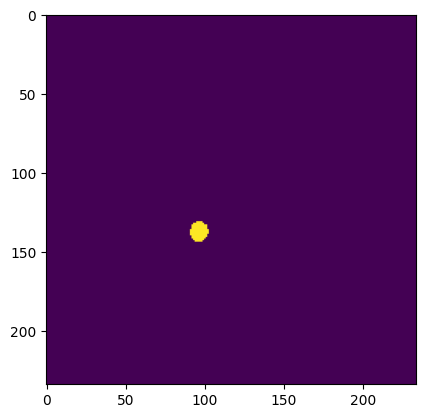

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(np.asarray(widget._track_gav[0])==1)

In [ ]:
gav = td.array.GraphArrayView(graph, attr_key="track_id" , shape=labels.shape)

In [ ]:
viewer.add_labels(gav)

<Labels layer 'gav' at 0x36a423e90>

In [ ]:
widget._cropped_verified_layer.data.

In [ ]:
import polars as pl
graph.node_attrs().filter(pl.col("track_id") ==1).sort("t")

node_id,t,mask,bbox,y,x,area,intensity_mean,track_id,termination_annotation,verified
i64,i64,object,list[i64],f64,f64,f64,f64,i64,null,i64
0,0,"Mask(bbox=[131:144, 91:103])","[131, 91, … 103]",137.033613,96.336134,119.0,72.705882,1,null,0
1000000024,1,"Mask(bbox=[129:147, 91:104])","[129, 91, … 104]",137.70297,97.183168,202.0,63.623762,1,null,0
2000000019,2,"Mask(bbox=[125:153, 96:105])","[125, 96, … 105]",137.97076,99.923977,171.0,62.0,1,null,0
3000000011,3,"Mask(bbox=[123:154, 96:104])","[123, 96, … 104]",138.745856,99.436464,181.0,59.983425,1,null,0
4000000000,4,"Mask(bbox=[123:155, 96:107])","[123, 96, … 107]",140.143541,100.009569,209.0,57.507177,1,null,0
5000000042,5,"Mask(bbox=[120:154, 94:105])","[120, 94, … 105]",138.306306,98.572072,222.0,58.743243,1,null,0
6000000022,6,"Mask(bbox=[129:156, 92:104])","[129, 92, … 104]",143.58547,97.474359,234.0,59.123932,1,null,0
7000000018,7,"Mask(bbox=[135:157, 92:103])","[135, 92, … 103]",145.734104,97.33526,173.0,60.040462,1,null,0
8000000008,8,"Mask(bbox=[137:157, 91:102])","[137, 91, … 102]",146.576159,96.245033,151.0,60.02649,1,null,0
